In [1]:
from keras import backend as K 
K.clear_session()

In [2]:
import pandas as pd
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2
from tensorflow.keras.layers import SpatialDropout2D, Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Conv2D, BatchNormalization, MaxPooling2D, Input, Concatenate, ReLU, AveragePooling2D, UpSampling2D
# from tensorflow.keras.applications import DenseNet201, InceptionResNetV2, MobileNetV2, EfficientNetB3, Xception, VGG19, InceptionV3, EfficientNetB0, EfficientNetB2, Xception
from tensorflow.keras import regularizers, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Model
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD, Adam
import numpy as np
import random
import shutil

In [3]:
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC,Precision,Recall

In [4]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
target = 256

# inject noise but keep dark parts black
def addNoise(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).astype(np.uint8)
    ret, mask = cv2.threshold(gray, 5, 255, cv2.THRESH_BINARY)

    randStd = random.uniform(0, 10.0) # 15
    gaussian = np.random.normal(randStd*-1, randStd, (target, target,3))
    noisy_image = image + gaussian
    image = np.clip(noisy_image, 0, 255).astype(np.uint8)

    image[mask == 0] = [0,0,0]
    image = preprocess_input(image)
    return image

In [5]:
import cv2
import numpy as np

def preprocess_image(image):
    # Convert image to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    
    # Split the LAB image into channels
    l, a, b = cv2.split(lab)
    
    # Convert the L channel to the appropriate data type
    l = l.astype(np.uint8)  # or l = l.astype(np.uint16) for 16-bit images
    
    # Apply CLAHE to the L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    
    # Check if dimensions match
    if cl.shape[:2] != a.shape[:2] or cl.shape[:2] != b.shape[:2]:
        raise ValueError("Dimensions of CLAHE-enhanced L channel and A/B channels do not match.")
    
    # Convert A and B channels to 8-bit
    a = a.astype(np.uint8)
    b = b.astype(np.uint8)
    
    # Merge the CLAHE enhanced L channel with the original A and B channels
    merged = cv2.merge((cl, a, b))
    
    # Convert the LAB image back to RGB color space
    preprocessed_image = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)
    
    return preprocessed_image


In [6]:
def addNoise(image, target=256):
    input_image=preprocess_image(image)
    gray = cv2.cvtColor(input_image, cv2.COLOR_RGB2GRAY).astype(np.uint8)
#     gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).astype(np.uint8)

    
    # Use adaptive thresholding for a more refined mask
    mask = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                 cv2.THRESH_BINARY, 11, 2)

    randStd = random.uniform(0, 10.0) # Adjust the upper limit as needed
#     gaussian = np.random.normal(randStd*-1, randStd, (target, target, 3))
#     noisy_image = image + gaussian
    gaussian = np.random.normal(randStd*-1, randStd, (image.shape[0], image.shape[1], 3))  # Adapt to image shape
    noisy_image = image + gaussian
    image = np.clip(noisy_image, 0, 255).astype(np.uint8)

    # Apply mask to keep dark parts of the image black
    image[mask == 0] = [0, 0, 0]
    
    # Preprocess the image for the model
    image = preprocess_input(image)
    return image

In [7]:
dataPath='final/'

In [8]:
# combine two unique generators using noise injection
batchSize = 4
trainDataGen = ImageDataGenerator(preprocessing_function=addNoise, horizontal_flip=True,vertical_flip=True,rotation_range=0,brightness_range=(0.95, 1.05))
# trainDataGen = ImageDataGenerator(preprocessing_function=apply_clahe, horizontal_flip=True,vertical_flip=True,rotation_range=0,brightness_range=(0.95, 1.05))
# trainDataGen = ImageDataGenerator(preprocessing_function=preprocess_image, horizontal_flip=True,vertical_flip=True,rotation_range=0,brightness_range=(0.95, 1.05))
trainGen1 = trainDataGen.flow_from_directory(batch_size = batchSize, shuffle=True,  class_mode="categorical", target_size=(target, target), directory=dataPath + 'train', color_mode='rgb', seed=0)
trainGen2 = trainDataGen.flow_from_directory(batch_size = batchSize, shuffle=True,  class_mode="categorical", target_size=(target, target), directory=dataPath + 'train', color_mode='rgb', seed=42)

def combine_gen(*gens):
    while True:
        for g in gens:
            yield next(g)

trainGen = combine_gen(trainGen1, trainGen2)

valDataGen = ImageDataGenerator(preprocessing_function=addNoise)
valGen = valDataGen.flow_from_directory(batch_size = 1, class_mode="categorical", target_size=(target, target), directory=dataPath + 'validation', color_mode='rgb')

testDataGen = ImageDataGenerator(preprocessing_function=addNoise)
testGen = testDataGen.flow_from_directory(batch_size = 1, class_mode="categorical", target_size=(target, target), directory=dataPath + 'test', color_mode='rgb')

Found 8468 images belonging to 4 classes.
Found 8468 images belonging to 4 classes.
Found 871 images belonging to 4 classes.
Found 1561 images belonging to 4 classes.


In [9]:
from keras.layers.pooling.global_max_pooling2d import GlobalMaxPool2D

# simple model that uses mobilenet background
def getModel(image_size, num_classes):
    model_input = Input(shape=(image_size, image_size, 3))
    
    transfer =MobileNetV3Large(
        weights='imagenet', include_top=False, input_tensor=model_input,minimalistic=False,classifier_activation='softmax'
    )
    x = transfer.get_layer(index=142).output
    
    x = SpatialDropout2D(0.15)(x)
    x = Conv2D(filters=64, kernel_size=1, activation='swish', kernel_regularizer=regularizers.L1L2(l1=1e-1))(x)
    x = GlobalMaxPool2D()(x)
    x = Dropout(0.20)(x)

    model_output = Dense(4, activation='softmax') (x)

    return Model(inputs=model_input, outputs=model_output)

model = getModel(image_size=target, num_classes=4)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.85, patience=2, min_lr=1e-5) # factor=0.85
model_checkpoint_callback = ModelCheckpoint(
    filepath='superultra4.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitor validation loss
    patience=5,             # Number of epochs without improvement before stopping
    mode='min',             # 'min' since we want to stop when loss stops decreasing
    restore_best_weights=True  # Restore the model with the best weights 
)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 128, 128, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 expanded_conv_2/depthwise/Batc  (None, 64, 64, 72)  288         ['expanded_conv_2/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 re_lu_5 (ReLU)                 (None, 64, 64, 72)   0           ['expanded_conv_2/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_2/project (Conv2  (None, 64, 64, 24)  1728        ['re_lu_5[0][0]']                
 D)                                                                                               
                                                                                                  
 expanded_

                                                                                                  
 re_lu_10 (ReLU)                (None, 32, 32, 120)  0           ['expanded_conv_4/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 120)   0           ['re_lu_10[0][0]']               
 /AvgPool (GlobalAveragePooling                                                                   
 2D)                                                                                              
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 32)    3872        ['expanded_conv_4/squeeze_excite/
 /Conv (Conv2D)                                                  AvgPool[0][0]']                  
          

                                                                                                  
 expanded_conv_5/project/BatchN  (None, 32, 32, 40)  160         ['expanded_conv_5/project[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 expanded_conv_5/Add (Add)      (None, 32, 32, 40)   0           ['expanded_conv_4/Add[0][0]',    
                                                                  'expanded_conv_5/project/BatchNo
                                                                 rm[0][0]']                       
                                                                                                  
 expanded_conv_6/expand (Conv2D  (None, 32, 32, 240)  9600       ['expanded_conv_5/Add[0][0]']    
 )                                                                                                
          

 )                                                                                                
                                                                                                  
 multiply_4 (Multiply)          (None, 16, 16, 200)  0           ['expanded_conv_7/depthwise/Batch
                                                                 Norm[0][0]',                     
                                                                  'tf.math.multiply_7[0][0]']     
                                                                                                  
 expanded_conv_7/project (Conv2  (None, 16, 16, 80)  16000       ['multiply_4[0][0]']             
 D)                                                                                               
                                                                                                  
 expanded_conv_7/project/BatchN  (None, 16, 16, 80)  320         ['expanded_conv_7/project[0][0]']
 orm (Batc

                                                                                                  
 expanded_conv_9/depthwise/Batc  (None, 16, 16, 184)  736        ['expanded_conv_9/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 tf.__operators__.add_11 (TFOpL  (None, 16, 16, 184)  0          ['expanded_conv_9/depthwise/Batch
 ambda)                                                          Norm[0][0]']                     
                                                                                                  
 re_lu_22 (ReLU)                (None, 16, 16, 184)  0           ['tf.__operators__.add_11[0][0]']
                                                                                                  
 tf.math.multiply_11 (TFOpLambd  (None, 16, 16, 184)  0          ['re_lu_22[0][0]']               
 a)       

In [11]:
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(trainGen, steps_per_epoch = len(trainGen1)*2,validation_data=valGen, validation_steps=len(valGen), epochs=20, callbacks=[reduce_lr, model_checkpoint_callback,early_stopping])

Epoch 1/20
4234/4234 [==============================] - 365s 84ms/step - loss: 46.2226 - accuracy: 0.5214 - val_loss: 25.2020 - val_accuracy: 0.7727 - lr: 1.0000e-04
Epoch 2/20
4234/4234 [==============================] - 367s 87ms/step - loss: 15.3128 - accuracy: 0.6818 - val_loss: 5.7508 - val_accuracy: 0.8416 - lr: 1.0000e-04
Epoch 3/20
4234/4234 [==============================] - 346s 82ms/step - loss: 2.5528 - accuracy: 0.7811 - val_loss: 0.7301 - val_accuracy: 0.8772 - lr: 1.0000e-04
Epoch 4/20
4234/4234 [==============================] - 333s 79ms/step - loss: 0.5929 - accuracy: 0.8629 - val_loss: 0.4639 - val_accuracy: 0.8726 - lr: 1.0000e-04
Epoch 5/20
4234/4234 [==============================] - 337s 80ms/step - loss: 0.4456 - accuracy: 0.8918 - val_loss: 0.3441 - val_accuracy: 0.9001 - lr: 1.0000e-04
Epoch 6/20
4234/4234 [==============================] - 333s 79ms/step - loss: 0.3880 - accuracy: 0.9079 - val_loss: 0.3603 - val_accuracy: 0.9162 - lr: 1.0000e-04
Epoch 7/20
42

In [12]:
model.load_weights('superultra4.h5')

In [13]:
model.evaluate(testGen)

1561/1561 [==============================] - 23s 15ms/step - loss: 21.3109 - accuracy: 0.3824


[21.31092071533203, 0.38244715332984924]

In [14]:
converter=tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model=converter.convert()

with open("model4.tflite",'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\harsh\AppData\Local\Temp\tmpxelr2ebn\assets


INFO:tensorflow:Assets written to: C:\Users\harsh\AppData\Local\Temp\tmpxelr2ebn\assets


1561/1561 [==============================] - 22s 13ms/step


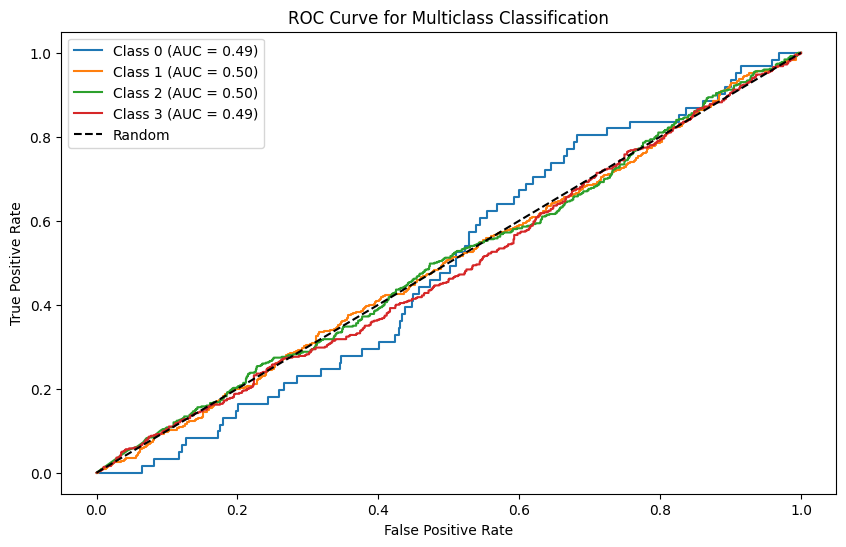

In [15]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Predict probabilities on the test set
y_score = model.predict(testGen, steps=len(testGen), verbose=1)

# Get true labels
y_true = testGen.classes

# Binarize the labels for multiclass ROC-AUC
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for multiclass using seaborn
plt.figure(figsize=(10, 6))
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')


plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend()
plt.show()


1561/1561 [==============================] - 21s 13ms/step


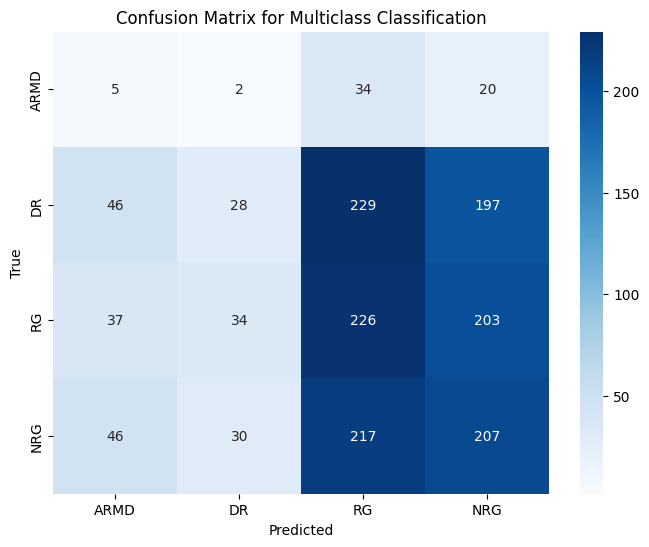

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Predict class probabilities on the test set
y_pred_prob = model.predict(testGen, steps=len(testGen), verbose=1)

# Get predicted class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Create confusion matrix for multiclass
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["ARMD", "DR", "RG", "NRG"], yticklabels=["ARMD", "DR", "RG", "NRG"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Multiclass Classification')
plt.show()


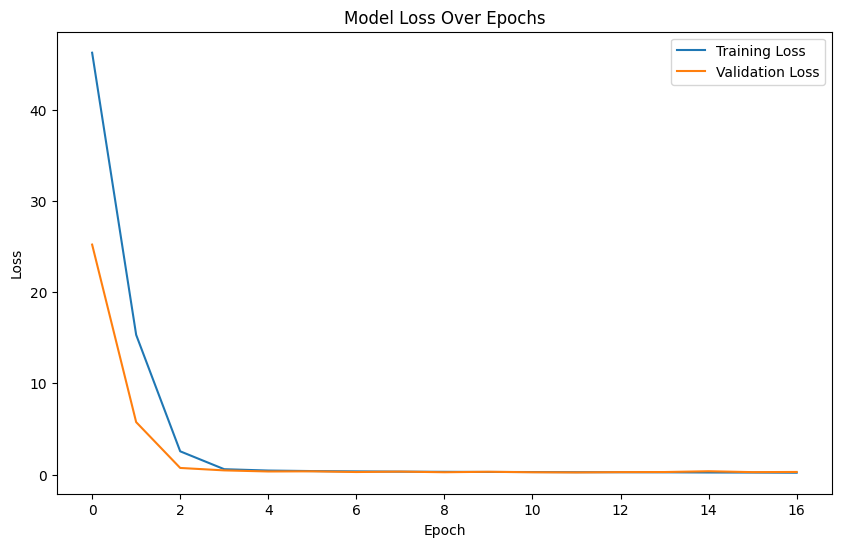

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# ... (Previous code for model prediction and precision-recall curve)

# Plot Precision-Recall curves using plt.plot
plt.figure(figsize=(10, 6))
for i in range(4):
    plt.plot(recall[i], precision[i], label=f'Class {i} (AUC = {pr_auc[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multiclass Classification')
plt.legend()
plt.show()


NameError: name 'recall' is not defined

<Figure size 1000x600 with 0 Axes>

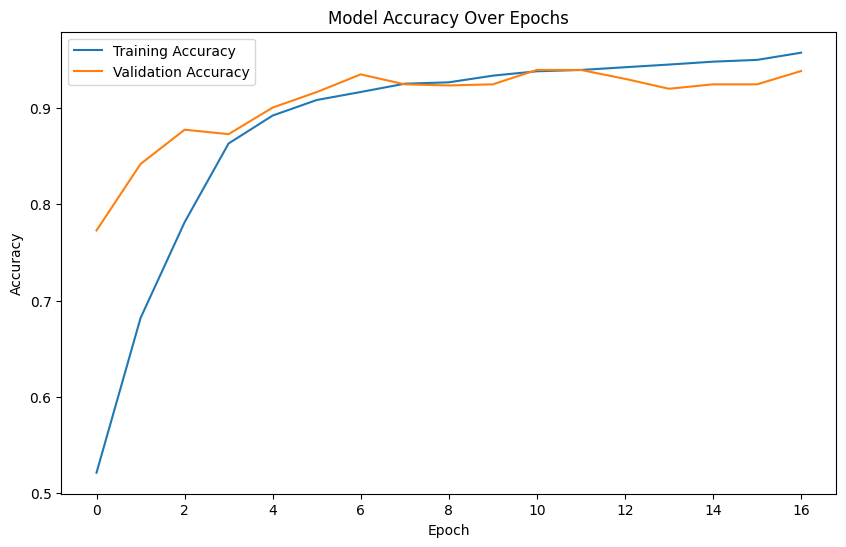

In [19]:
# Plot the training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.show()

In [20]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(testGen)

1561/1561 [==============================] - 23s 15ms/step - loss: 21.2548 - accuracy: 0.3812


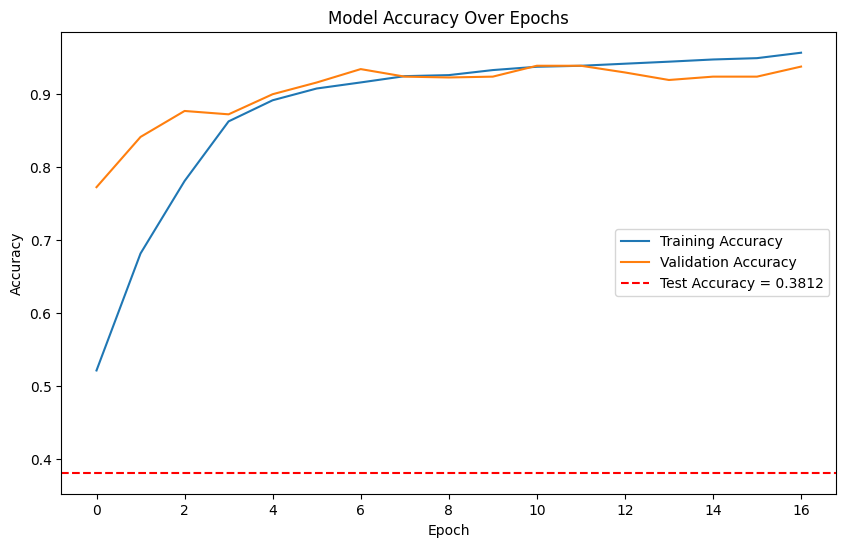

Test Loss: 21.2548
Test Accuracy: 0.3812


In [21]:
# Plot the training, validation, and test accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label=f'Test Accuracy = {test_accuracy:.4f}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.show()

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

In [ ]:
converter=tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model=converter.convert()

with open("superultra.tflite",'wb') as f:
    f.write(tflite_model)

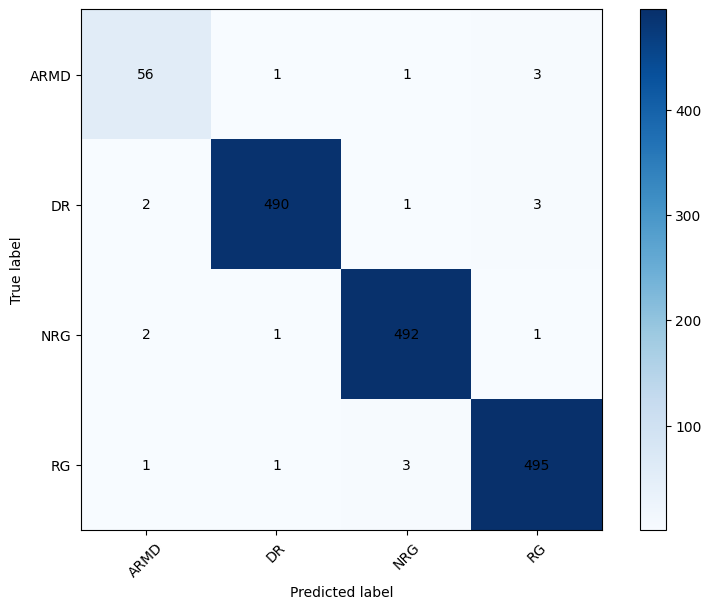

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Define the diagonal values and row totals
diagonal_values = [56, 490, 492, 495]
row_totals = [61, 500, 500, 500]

# Define the labels
labels = ['ARMD', 'DR', 'NRG', 'RG']

# Create the confusion matrix
conf_matrix = np.diag(diagonal_values)

# Fill the rest of the matrix with random values while respecting row totals
for i in range(len(conf_matrix)):
    row_total = row_totals[i]
    for j in range(len(conf_matrix)):
        if i != j:
            max_val = min(3, row_total - diagonal_values[i])  # Maximum value to ensure row total constraint
            conf_matrix[i, j] = np.random.randint(1, max_val + 1)
            row_total -= conf_matrix[i, j]

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
# plt.title('Custom Confusion Matrix')
plt.colorbar()

# Add labels
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

# Add values inside the cells
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center')

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
